In [3]:
import networkx as nx
from scipy.linalg import expm, sinm, cosm
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import osmnx as ox
from sklearn.metrics import mean_squared_error

In [49]:
def cosine_distance(G, comm = None): # returns a dataframe with a matrix
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)

    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    cd = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            cd[i][j] =2 - 2*comm[i][j]/np.sqrt(comm[i][i]*comm[j][j])
    return cd

def comm_angle(G, comm = None):
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)
    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    angle = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            angle[i][j] =np.degrees(np.arccos(comm[i][j]/np.sqrt(comm[i][i]*comm[j][j])))
    return angle




def comm_distance(G, comm = None): # returns a dataframe with a matrix
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)

    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    cd = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            cd[i][j] =np.sqrt(comm[i][i] + comm[j][j] - 2*comm[i][j])
    return cd

def comm_geo(G, cd = None, comm = None): # adds mean flow as attribute and returns a matrix
  G_simple = nx.Graph(G)
  if cd is None:
    if comm is None:
      comm = add_comm_attr(G_simple)
    cd = comm_distance(G_simple, comm)
  dfA = nx.to_pandas_adjacency(G)
  X = (dfA*cd)
  GX = nx.from_pandas_adjacency(X, nx.DiGraph)
  dfSP = nx.to_pandas_adjacency(G)
  j = dict()
  for i in list(G.edges):
    try:
      j[i[0], i[1]] =  nx.dijkstra_path_length(GX, i[1], i[0], weight = "weight")
    except:
      j[i[0], i[1]] = 0

  # teste = pd.DataFrame.from_dict(j, orient = "index")
  # for i in teste.columns:
  #   for j in teste.columns:
  #     if np.isnan(teste[i][j]):
  #       dfSP[i][j] = 0
  #     else:
  #       dfSP[i][j] = teste[i][j]
  # nx.set_node_attributes(G, values=(dfSP.mean()).to_dict(), name="mean_flow")
  return j, cd


def add_CCC(G, comm = None, cd = None): # returns a dict with a centrality
    if cd is None:
        cd = cosine_distance(G,comm)
    d = (1/cd.sum())
    nx.set_node_attributes(G, values=d.to_dict(), name="CCC")
    return d




def add_comm_attr(G): # matrix and mean comm as attr
    # G_simple = nx.Graph(G)
    nodelist = list(G)
    A = nx.to_numpy_array(G, nodelist)

    Aexp2 = expm(A)
    mapping = dict(zip(nodelist, range(len(nodelist))))

    c = {}
    d = {}
    for u in G:
        c[u] = {}
        for v in G:
            c[u][v] = float(Aexp2[mapping[u], mapping[v]])
        d[u] = np.mean(list(c[u].values()))

    nx.set_node_attributes(G, values=d, name="comm")
    return c

def plotting(G, value, pos = None):
    groups = nx.get_node_attributes(G,value).values()
    mapping = dict(zip(count(),sorted(groups)))

    nodes = G.nodes()
    colors = [mapping[n] for n in nodes]

    # drawing nodes and edges separately so we can capture collection for colobar
    if not pos:
        pos = nx.spring_layout(G)
    plt.figure(figsize=(10,10))
    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()


def graph_folium_bg(G, n_attribute = None, e_attribute = None, cmap = "hot", poly = None):
    nodes, edges = ox.graph_to_gdfs(G)
    if poly is not None:
        m = poly.explore()
        m = edges.explore(m=m, column = e_attribute, cmap = cmap, color = "black")
    else:
        m = edges.explore(column = e_attribute, cmap = cmap, color = "black")
    m = nodes.explore(m=m, column = n_attribute, cmap = cmap, color = "black")
    return m

def calculations(G):
    flow, X = comm_geo(G)
    nx.set_edge_attributes(G, flow, "Flow of returnal")
    bet = nx.edge_betweenness_centrality(G, normalized = False)
    nx.set_edge_attributes(G, bet, "Betweenness")

    j = dict()
    for i in list(G.edges):
        try:
            j[i[0], i[1]] =  nx.dijkstra_path_length(G, i[1], i[0])
        except:
            j[i[0], i[1]] = 0

    df = pd.DataFrame(flow.values(), columns = ["Cost"], index = G.edges())
    df["Betweenness"] = bet.values()
    df["SP_inverse"] = j.values()
    return df, X

seed = 555
nodes = 1000

## Random

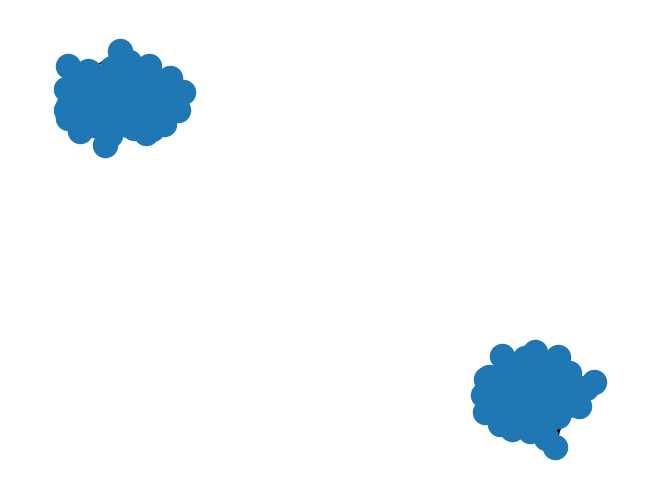

In [5]:
G = nx.union(nx.fast_gnp_random_graph(100, 0.1, directed = True), nx.fast_gnp_random_graph(100, 0.1, directed = True), rename = ("G", "H"))
pos = nx.draw_spring(G)
n = 100
G.add_edge('G0', 'H0')
G.add_edge(f'H{int(n/2)}', f'G{int(n/2)}')

In [6]:
df = calculations(G)

              G0   G1   G2          G3   G4   G5           G6           G7  \
G0      0.000000  0.0  0.0    0.000000  0.0  0.0  1413.431155     0.000000   
G1    271.612388  0.0  0.0  180.475501  0.0  0.0     0.000000  1249.842060   
G2   1093.264486  0.0  0.0    0.000000  0.0  0.0     0.000000     0.000000   
G3      0.000000  0.0  0.0    0.000000  0.0  0.0     0.000000  1069.769121   
G4      0.000000  0.0  0.0  881.047560  0.0  0.0     0.000000     0.000000   
..           ...  ...  ...         ...  ...  ...          ...          ...   
H95     0.000000  0.0  0.0    0.000000  0.0  0.0     0.000000     0.000000   
H96     0.000000  0.0  0.0    0.000000  0.0  0.0     0.000000     0.000000   
H97     0.000000  0.0  0.0    0.000000  0.0  0.0     0.000000     0.000000   
H98     0.000000  0.0  0.0    0.000000  0.0  0.0     0.000000     0.000000   
H99     0.000000  0.0  0.0    0.000000  0.0  0.0     0.000000     0.000000   

             G8           G9  ...  H90         H91         H92 

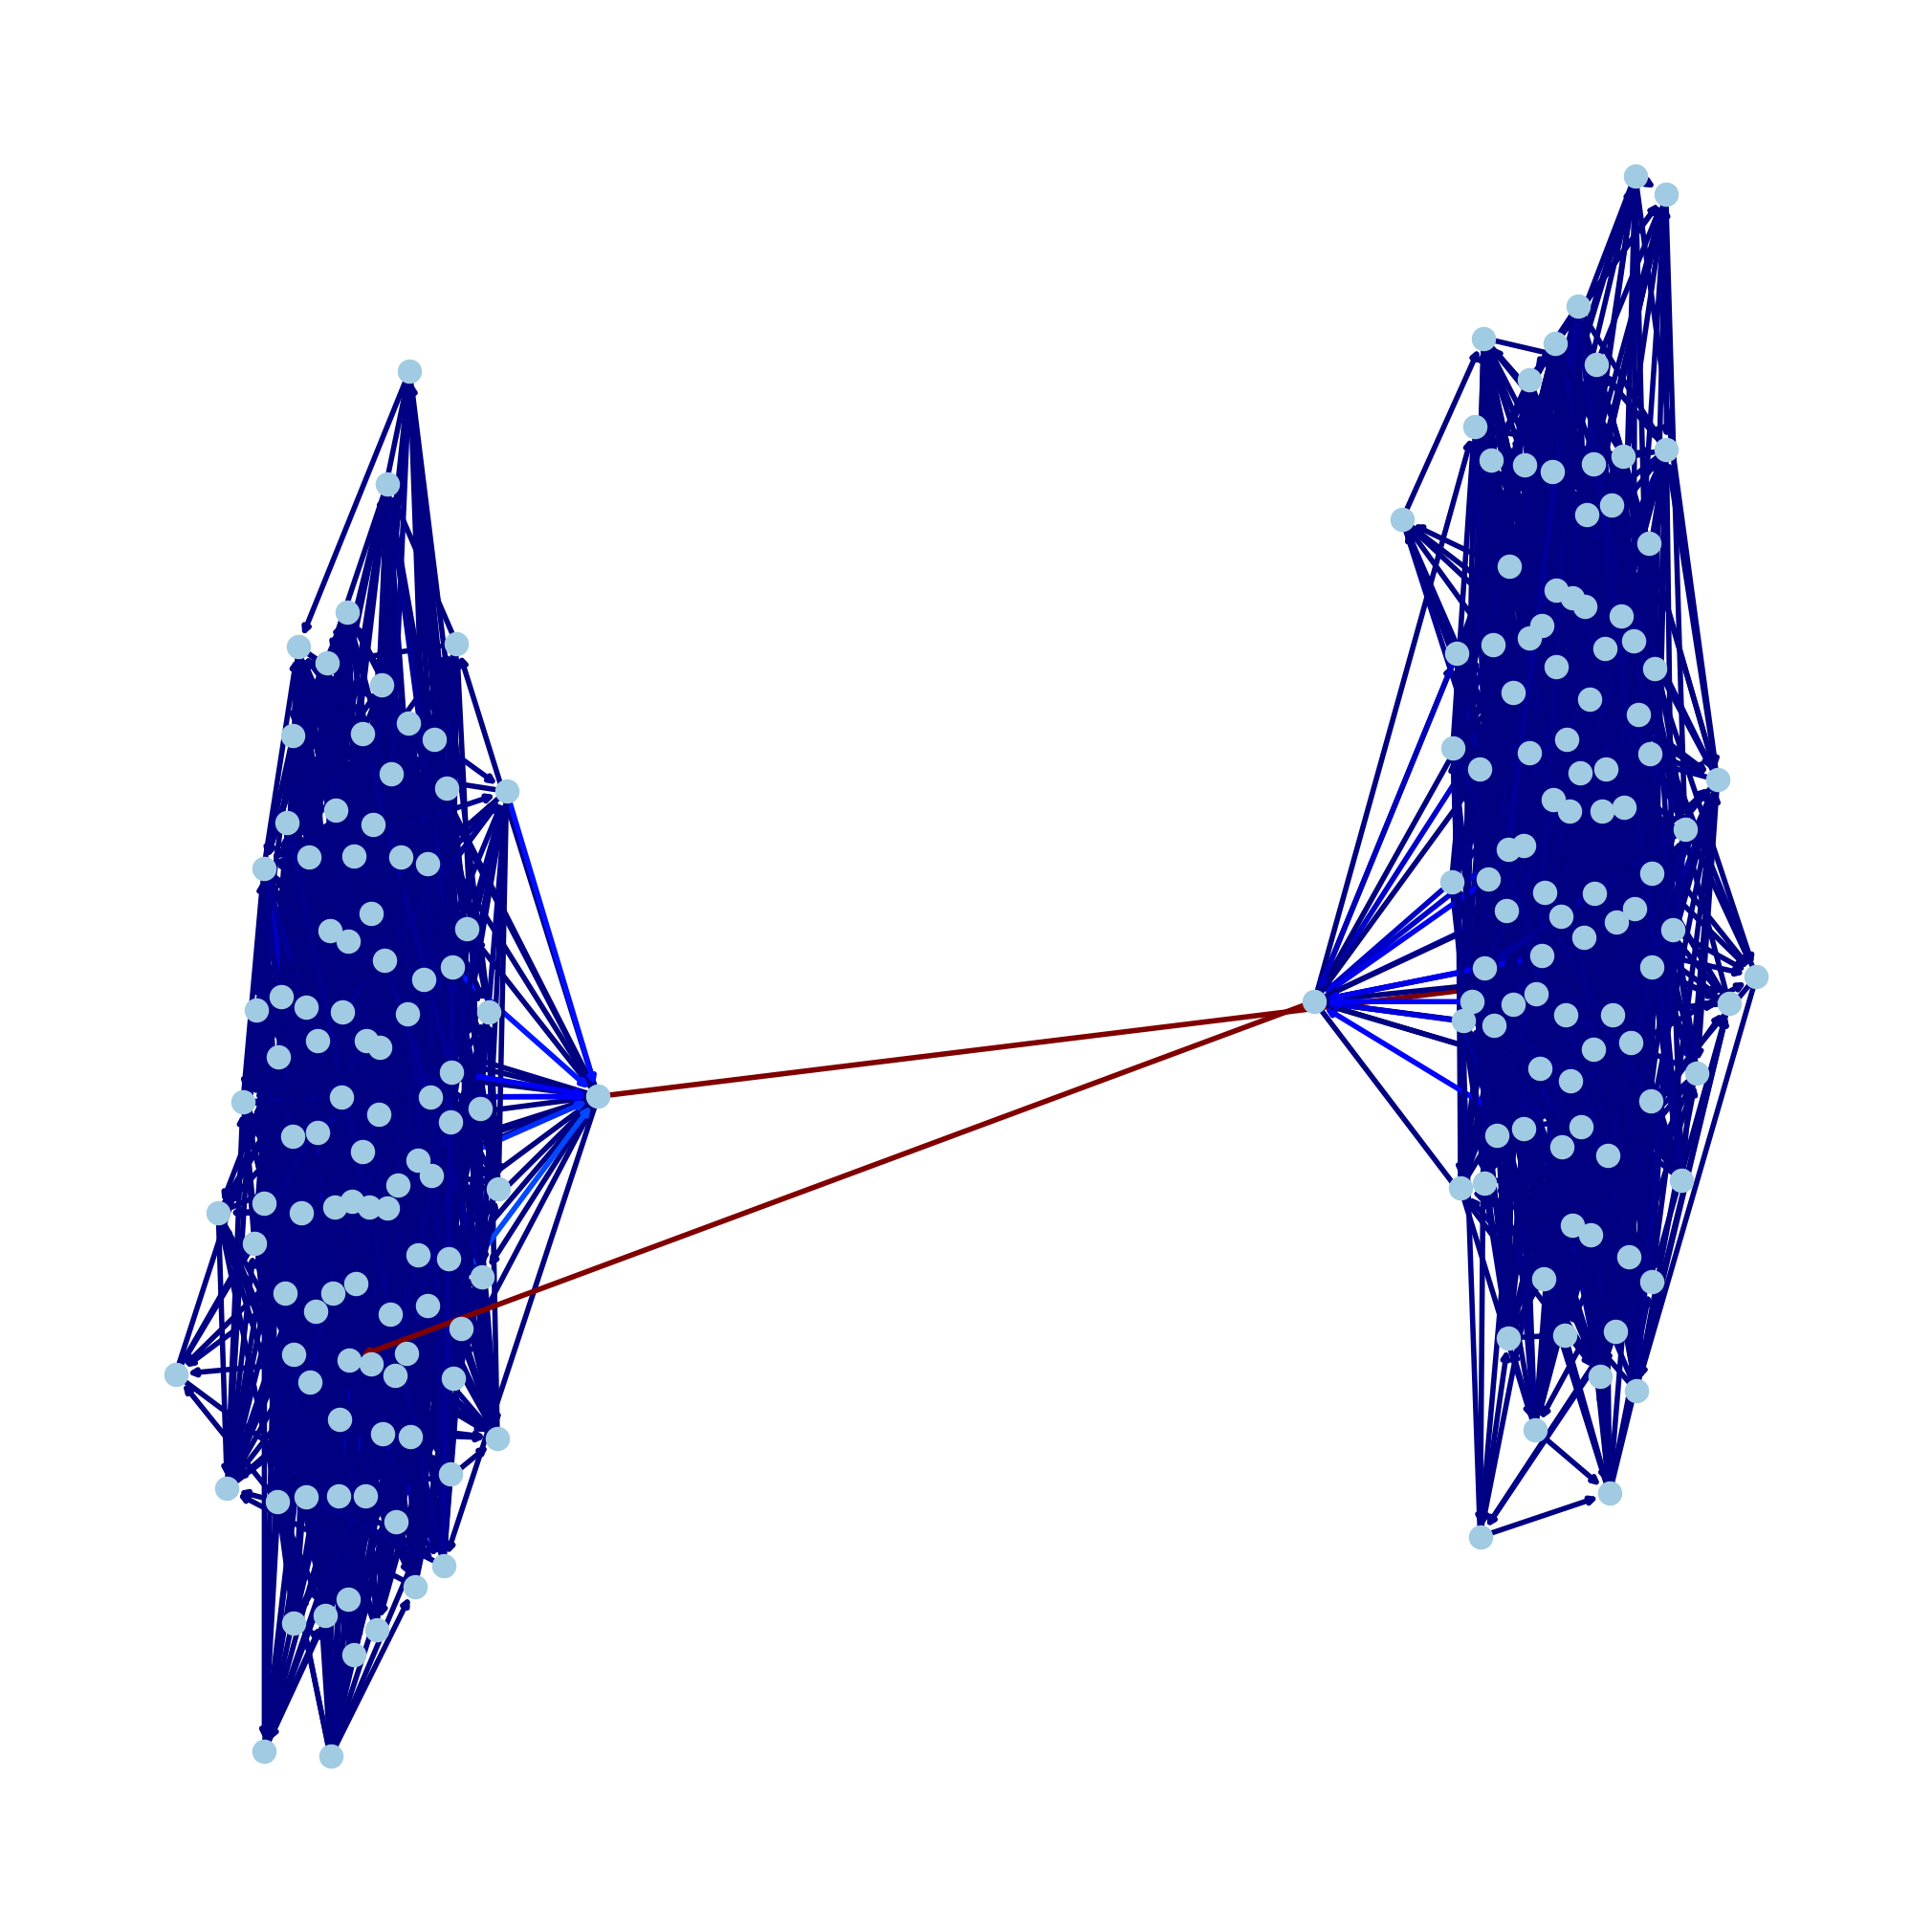

In [7]:
options = {
    "node_color": "#A0CBE2",
    "edge_color": df["Betweenness"],
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "with_labels": False,
}
plt.figure(figsize=(20,20))
nx.draw(G, **options, pos = pos)

In [8]:
px.histogram(df, x = "Betweenness")

In [9]:
px.histogram(df, x = "Cost")

In [10]:
px.scatter(df, x = "Cost", y = "Betweenness")

## Cycle

In [11]:
n = 50
GT = nx.cycle_graph(n, nx.Graph())
Test = nx.union(GT, GT, rename = ("G", "H"))
Test = nx.DiGraph(Test)
Test.add_edge('G0', 'H0')
Test.add_edge(f'H{int(n/2)}', f'G{int(n/2)}')


In [12]:
df

Cost  Betweenness  SP_inverse
G0  G6   1415.855938    17.119390           2
    G9   1368.477958    15.517613           3
    G12   856.704849    14.652426           3
    G13   709.805123     9.575559           2
    G20  1478.896969    22.101703           2
...              ...          ...         ...
H99 H51   378.563523    40.375335           2
    H52   827.444424    17.805780           2
    H56   770.107597    36.357310           2
    H69   259.938073    26.069421           2
    H96   191.902139    33.942682           2

[2032 rows x 3 columns]

           G0        G1        G2        G3        G4        G5   G6   G7  \
G0   0.000000  1.341652  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
G1   1.341652  0.000000  1.189240  0.000000  0.000000  0.000000  0.0  0.0   
G2   0.000000  1.189240  0.000000  1.174369  0.000000  0.000000  0.0  0.0   
G3   0.000000  0.000000  1.174369  0.000000  1.173848  0.000000  0.0  0.0   
G4   0.000000  0.000000  0.000000  1.173848  0.000000  1.173839  0.0  0.0   
..        ...       ...       ...       ...       ...       ...  ...  ...   
H45  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
H46  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
H47  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
H48  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
H49  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   

      G8   G9  ...  H40  H41  H42  H43       H44       H45       H46  \
G0 

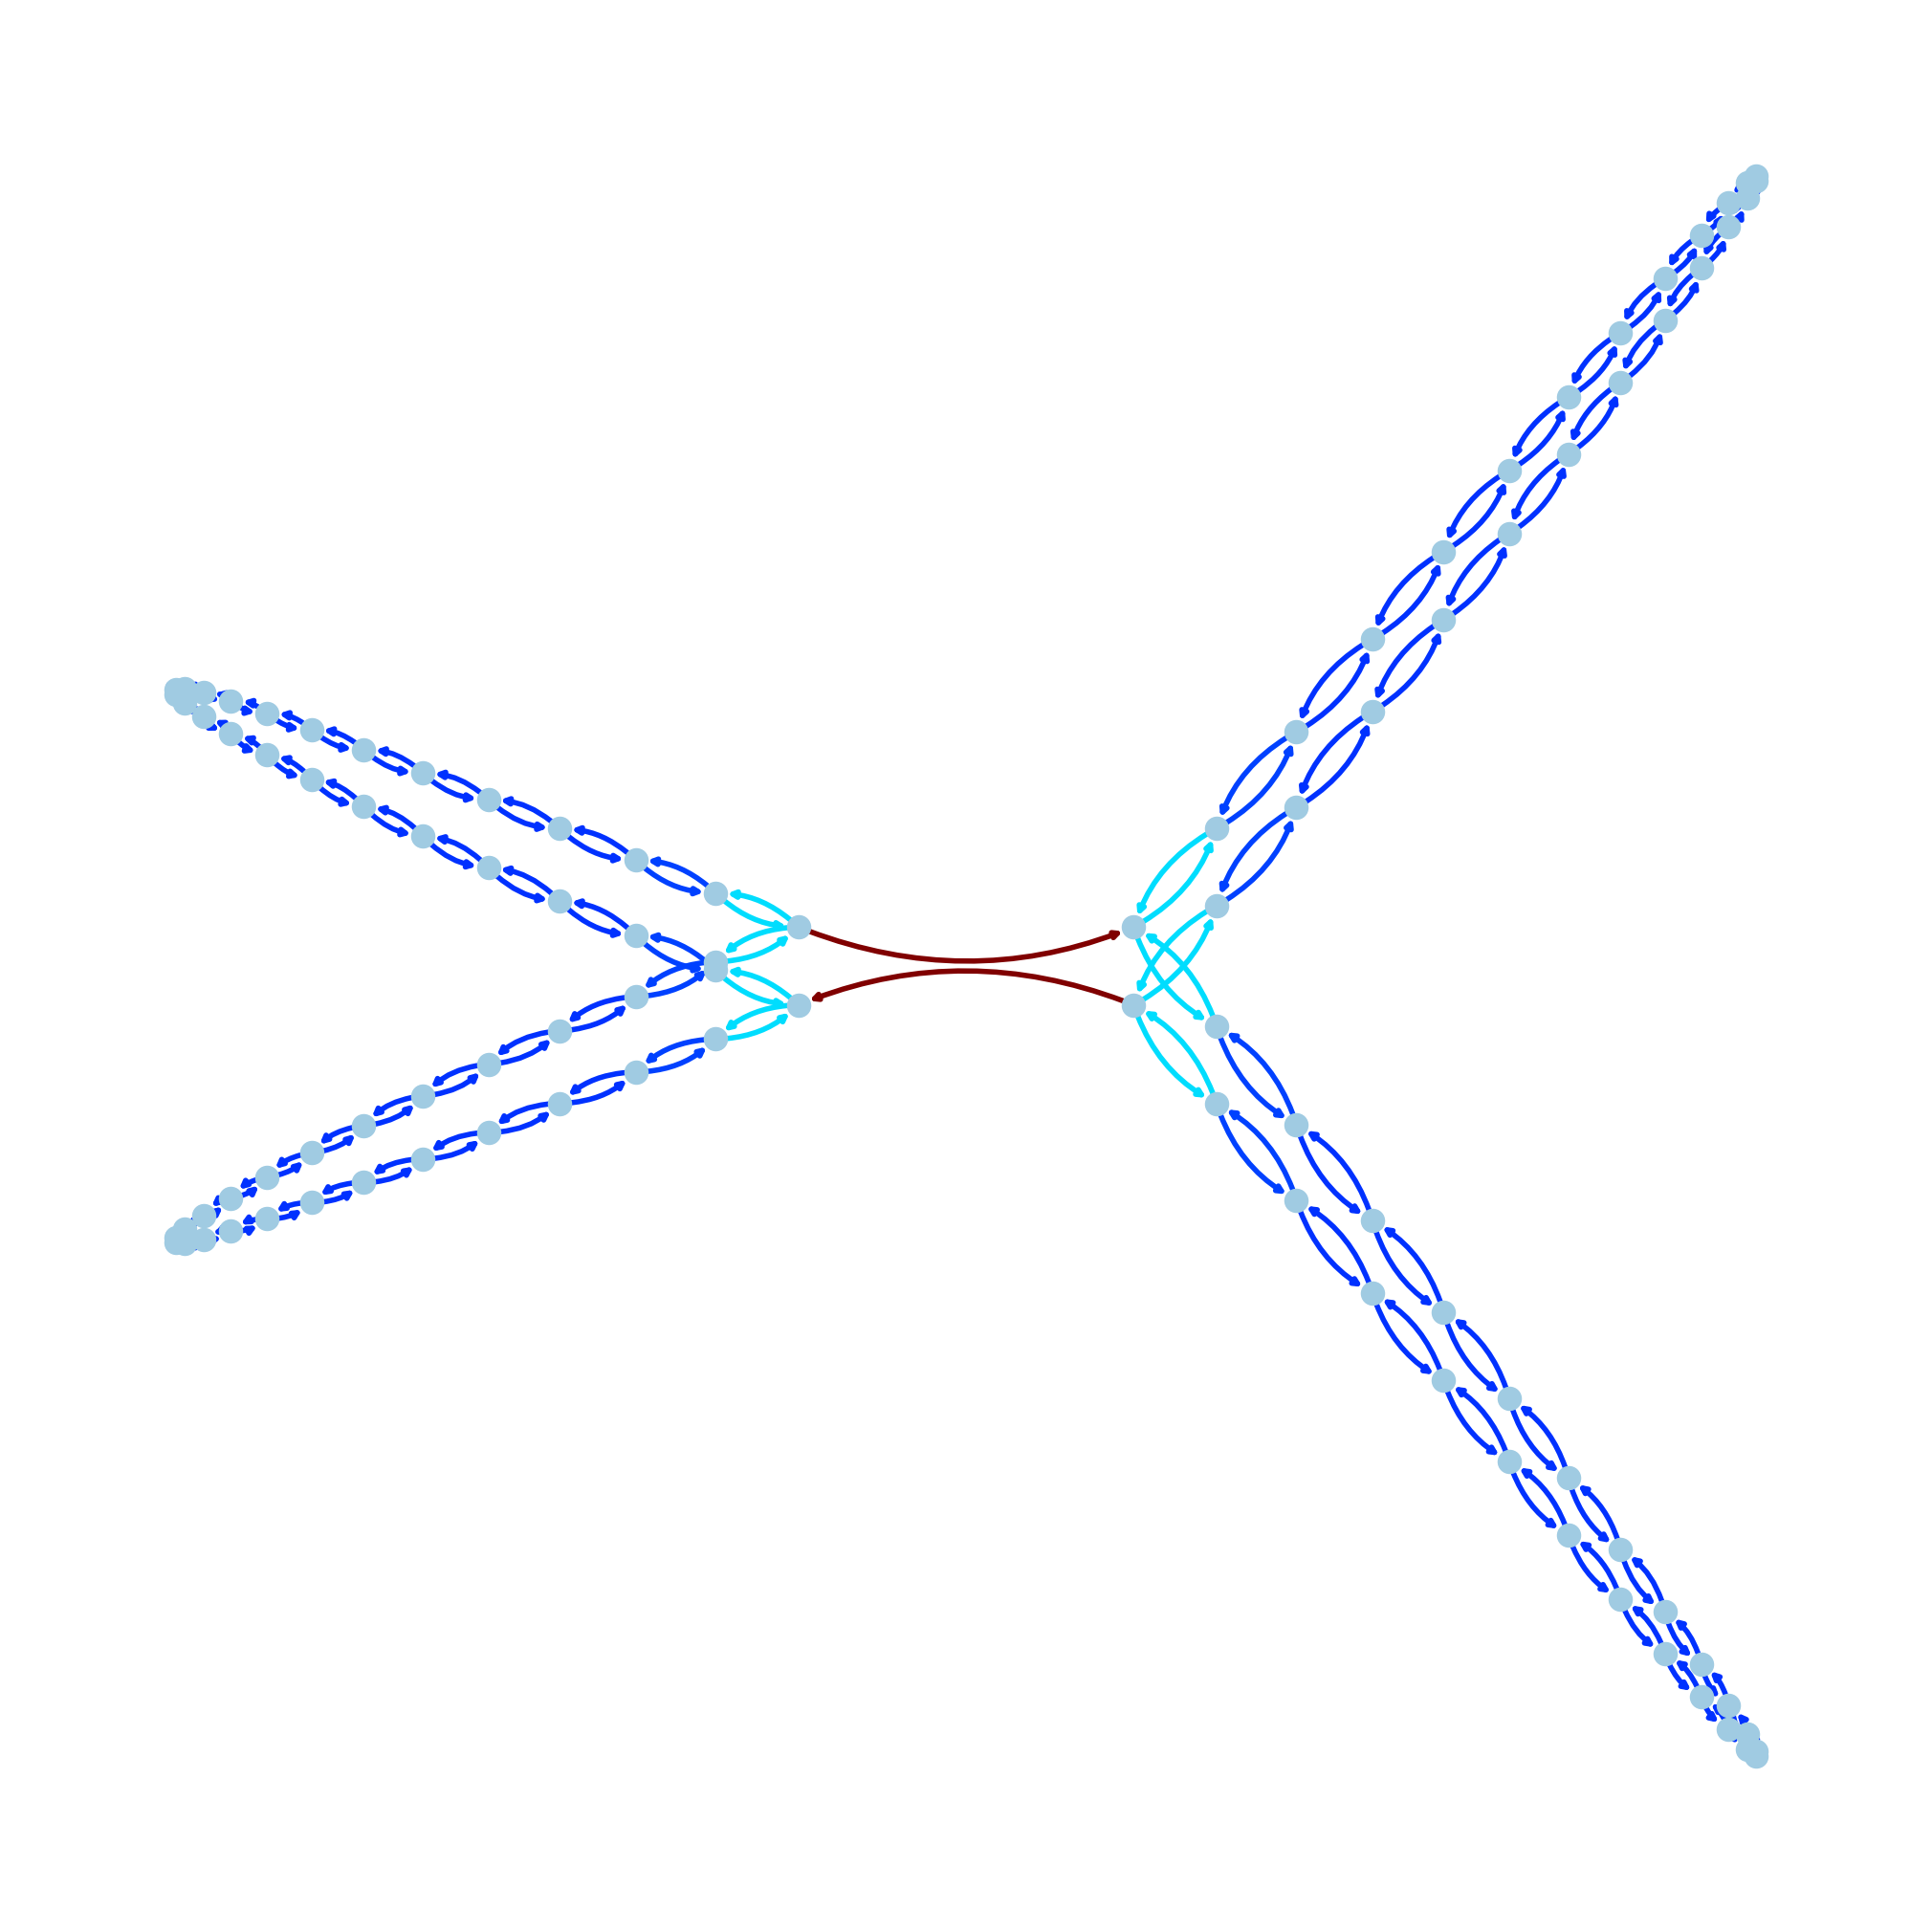

In [13]:
df = calculations(Test)

options = {
    "node_color": "#A0CBE2",
    "edge_color": df["Cost"],
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "with_labels": False,
    "edge_vmin": 1,
    "edge_vmax": 2
}
plt.figure(figsize=(20,20))
nx.draw_spectral(Test, connectionstyle='arc3, rad = 0.2', **options)

## Grid

In [14]:
_G = nx.DiGraph(nx.grid_2d_graph(10,10))
pos = {f'G({x}, {y})':(y,-x) for x,y in _G.nodes()}
pos.update({f'H({x}, {y})':(y, 20-x) for x,y in _G.nodes()})
G = nx.union(_G, _G, rename = ("G", "H"))
G.add_edge("H(9, 9)", "G(0, 9)")
G.add_edge("G(0, 0)", "H(9, 0)")

          G(0, 0)   G(0, 1)   G(0, 2)   G(0, 3)   G(0, 4)  G(0, 5)  G(0, 6)  \
G(0, 0)  0.000000  1.445969  0.000000  0.000000  0.000000  0.00000      0.0   
G(0, 1)  1.445969  0.000000  1.476710  0.000000  0.000000  0.00000      0.0   
G(0, 2)  0.000000  1.476710  0.000000  1.480316  0.000000  0.00000      0.0   
G(0, 3)  0.000000  0.000000  1.480316  0.000000  1.480448  0.00000      0.0   
G(0, 4)  0.000000  0.000000  0.000000  1.480448  0.000000  1.48045      0.0   
...           ...       ...       ...       ...       ...      ...      ...   
H(9, 5)  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.0   
H(9, 6)  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.0   
H(9, 7)  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.0   
H(9, 8)  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.0   
H(9, 9)  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.0   

         G(0, 7)  G(0, 8)   G(0, 9)  ...   H(9, 0) 

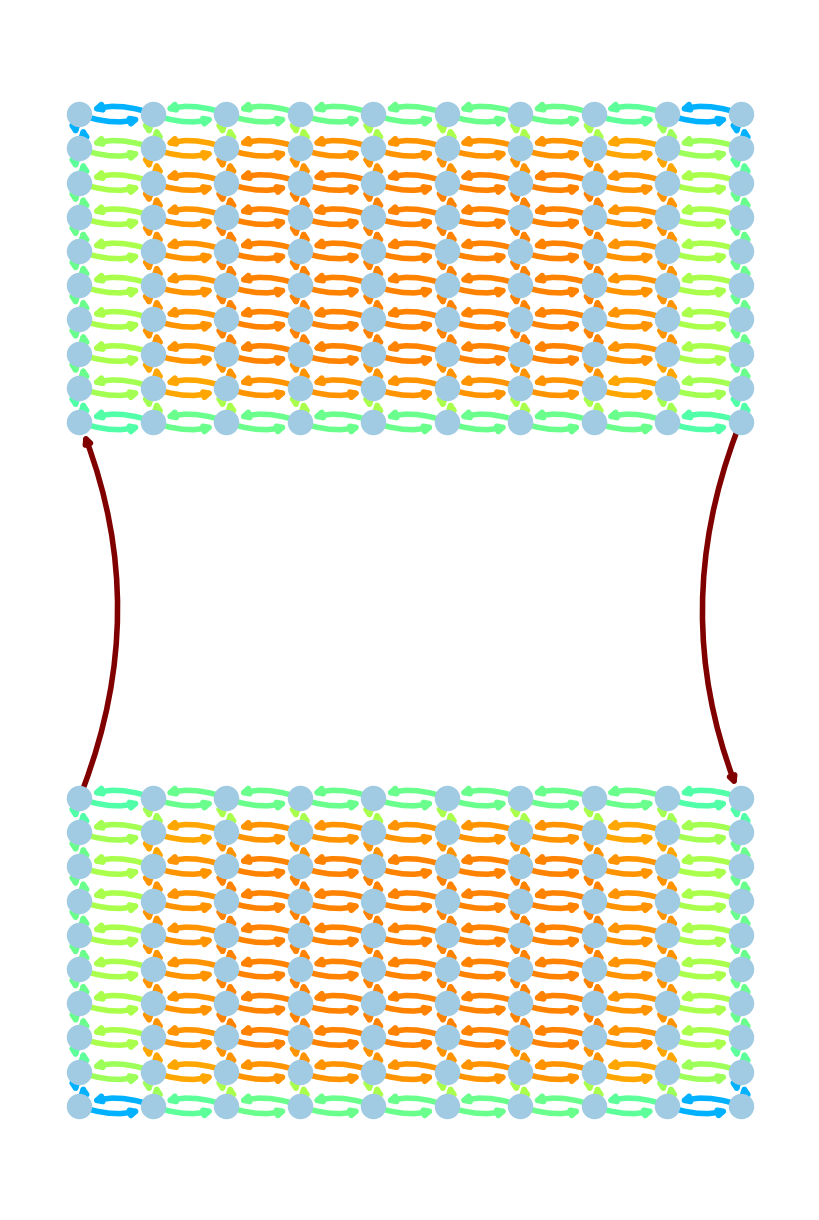

In [15]:
df = calculations(G)

options = {
    "node_color": "#A0CBE2",
    "edge_color": df["Cost"],
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "with_labels": False,
    "edge_vmin": 1,
    "edge_vmax": 2
}
plt.figure(figsize=(8,12))
nx.draw(G, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)

In [16]:
df

Cost   Betweenness  SP_inverse
G(0, 0) G(1, 0)   1.445969     66.433168           1
        G(0, 1)   1.445969     53.935739           1
        H(9, 0)  28.070427  10000.000000          19
G(0, 1) G(1, 1)   1.547190    112.766121           1
        G(0, 0)   1.445969   5116.433168           1
...                    ...           ...         ...
H(9, 8) H(9, 7)   1.476710     83.484658           1
        H(9, 9)   1.445969   5116.433168           1
H(9, 9) H(8, 9)   1.445969     66.433168           1
        H(9, 8)   1.445969     53.935739           1
        G(0, 9)  28.070427  10000.000000          19

[722 rows x 3 columns]

In [17]:
px.scatter(df, x = "Cost", y = "SP_inverse")

## Scale-free

In [18]:
_G1 = nx.DiGraph(nx.scale_free_graph(100))
_G2 = nx.DiGraph(nx.scale_free_graph(100))
pos1 = nx.kamada_kawai_layout(_G1)
pos1 = {f'G{i}' : j for i,j in zip(pos1,pos1.values())}
pos2 = nx.kamada_kawai_layout(_G2)
pos2 = {f'H{i}' : j+2 for i,j in zip(pos2,pos2.values())}
pos1.update(pos2)
G = nx.union(_G1, _G2, rename = ("G", "H"))
G.add_edge("G0", "H0")
G.add_edge("H99", "G99")
df = calculations(G)


            G0         G1         G2   G3      G4   G5   G6         G7   G8  \
G0    0.000000  28.384430   0.000000  0.0  0.0000  0.0  0.0   0.000000  0.0   
G1    0.000000   0.000000  39.823336  0.0  0.0000  0.0  0.0   0.000000  0.0   
G2   13.939160  39.823336   0.000000  0.0  0.0000  0.0  0.0   7.037590  0.0   
G3   17.351535  43.450818   4.222997  0.0  2.9321  0.0  0.0  10.318281  0.0   
G4   19.247032  45.115491   0.000000  0.0  0.0000  0.0  0.0   0.000000  0.0   
..         ...        ...        ...  ...     ...  ...  ...        ...  ...   
H95   0.000000   0.000000   0.000000  0.0  0.0000  0.0  0.0   0.000000  0.0   
H96   0.000000   0.000000   0.000000  0.0  0.0000  0.0  0.0   0.000000  0.0   
H97   0.000000   0.000000   0.000000  0.0  0.0000  0.0  0.0   0.000000  0.0   
H98   0.000000   0.000000   0.000000  0.0  0.0000  0.0  0.0   0.000000  0.0   
H99   0.000000   0.000000   0.000000  0.0  0.0000  0.0  0.0   0.000000  0.0   

      G9  ...  H90  H91  H92  H93  H94  H95  H96  H

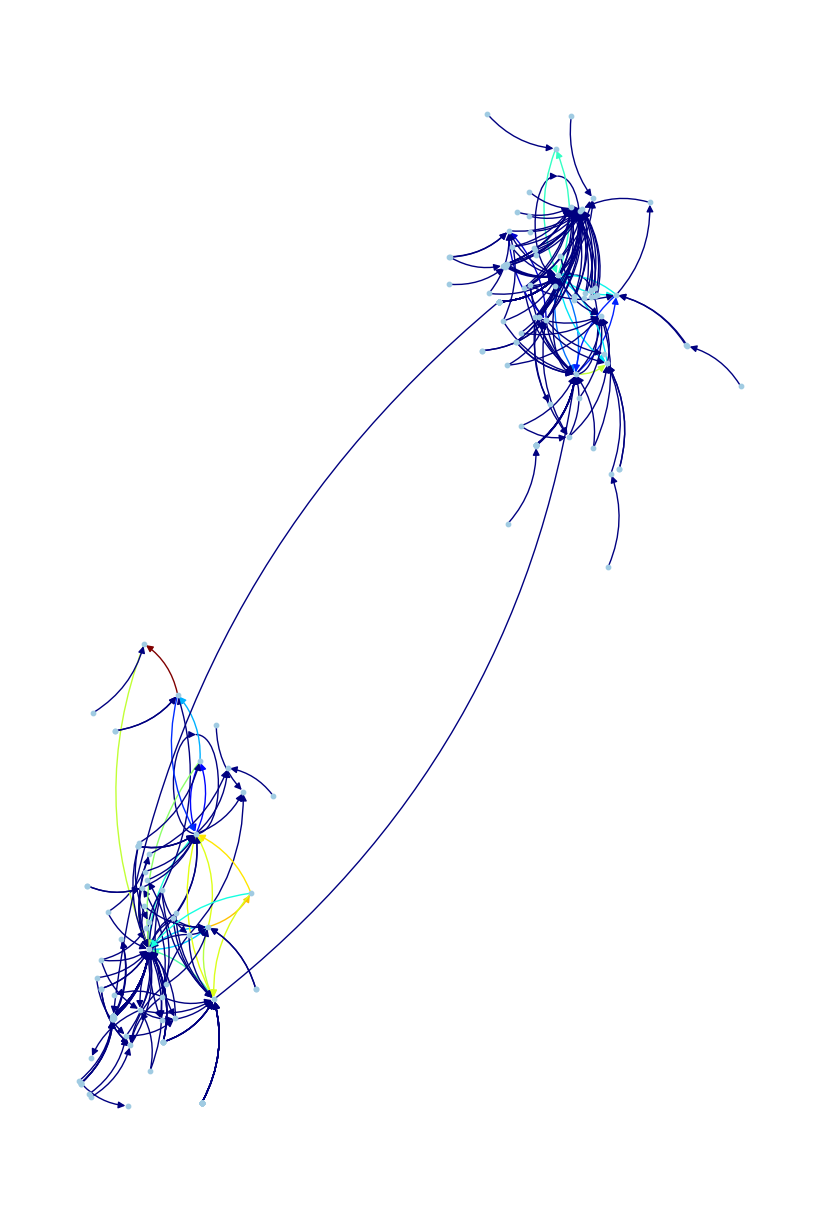

In [19]:

options = {
    "node_color": "#A0CBE2",
    "node_size" : 10,
    "edge_color": df["Cost"],
    "width": 1,
    "edge_cmap": plt.cm.jet,
    "with_labels": False,
}
plt.figure(figsize=(8,12))
nx.draw(G, pos = pos1, connectionstyle='arc3, rad = 0.2', **options)

In [20]:
px.scatter(df, x = "Cost", y = "SP_inverse")

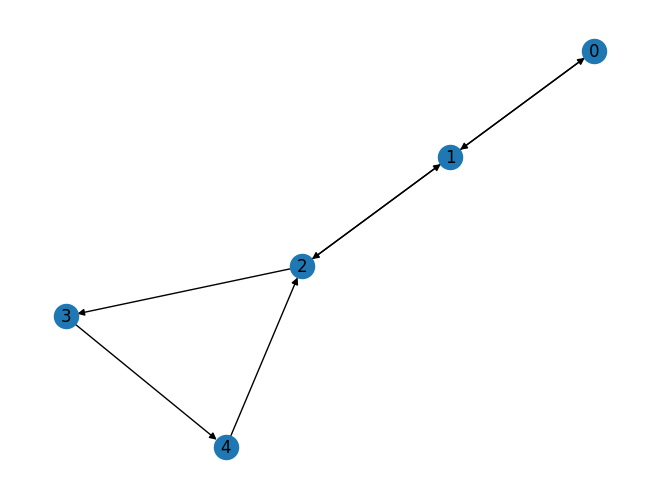

In [34]:
el = [[2, 1],
[2, 3],
[4, 2],
[0, 1],
[1, 2],
[1, 0],
[3, 4]]

G = nx.from_edgelist(el, create_using=nx.DiGraph)
H = nx.DiGraph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))
pos = nx.kamada_kawai_layout(H)
nx.draw(H, with_labels = True, pos = pos)

In [22]:
H.nodes

NodeView((0, 1, 2, 3, 4))

In [50]:
df, X = calculations(H)


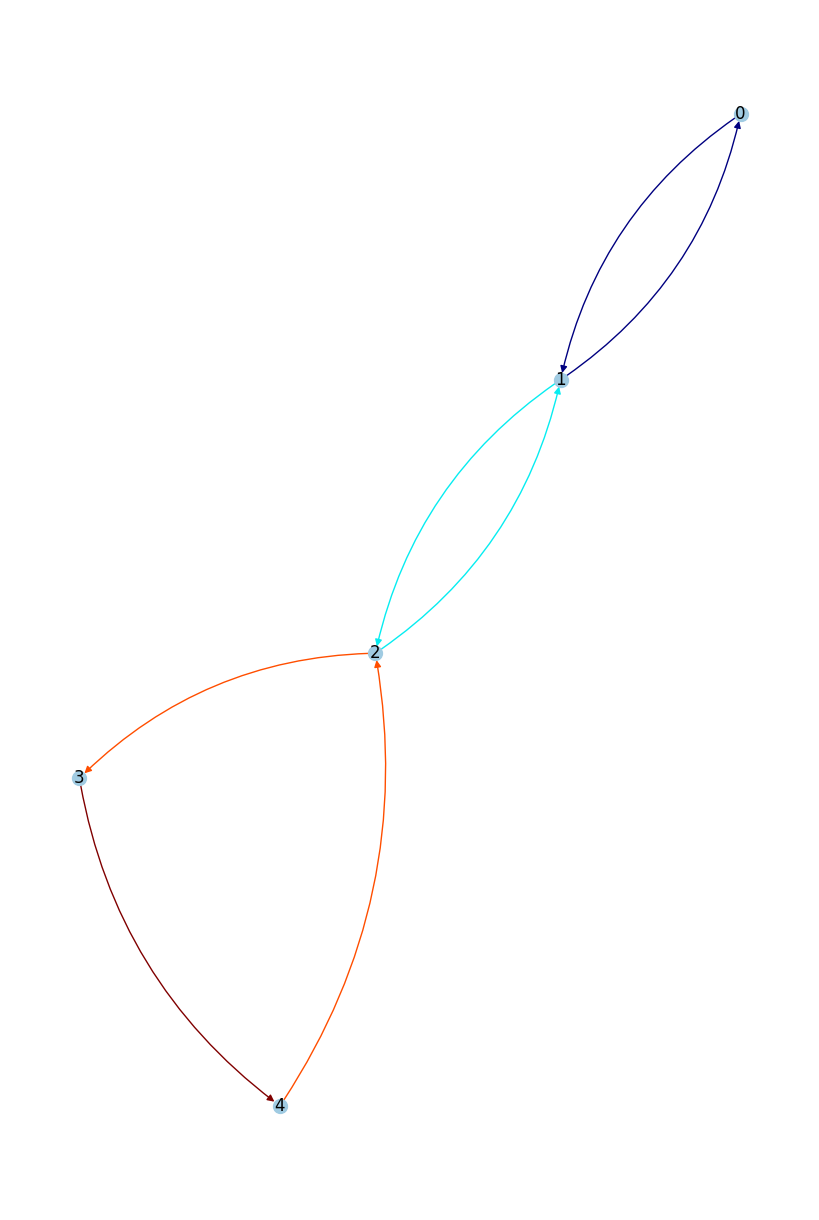

In [37]:

options = {
    "node_color": "#A0CBE2",
    "node_size" : 100,
    "edge_color": df["Cost"],
    "width": 1,
    "edge_cmap": plt.cm.jet,
    "with_labels": True,
}
plt.figure(figsize=(8,12))
nx.draw(H, connectionstyle='arc3, rad = 0.2', **options, pos = pos)

In [38]:
df

Cost  Betweenness  SP_inverse
0 1  1.055334          4.0           1
1 2  1.415646          6.0           1
  0  1.055334          4.0           1
2 1  1.415646          6.0           1
  3  1.889327          7.0           2
3 4  2.063126          7.0           2
4 2  1.889327          7.0           2